# Email classification using Random forest trees and Linear Regression
In this project we will train a random forest algorithm and apply it a spambase dataset.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Dataset ](#2)

<a name="1"></a>
## 1 - Packages 
 We will start by importing all the necessary packages for this project.
 - [scikit-learn](https://scikit-learn.org/stable/index.html) is a library used for the random forest implementation

In [21]:

#Data visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#Tree visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image


<a name="2"></a>
## 2 - Dataset
We will be working with the  [spambase](https://archive.ics.uci.edu/dataset/94/spambase) dataset provided by the UCI machine learning repository. This dataset has 57 features and 1 target.
We start by checking the dataset for missing values:

In [22]:
#Check if the dataset has missing values.

data_file_path = 'dataset/spambase_data'
names_file_path = 'dataset/column_names.txt'

with open(names_file_path, 'r') as file:
    column_names = [line.strip() for line in file if line.strip()]

column_names.append('is_spam')

data = pd.read_csv(data_file_path, header=None, names=column_names)

# Check for missing values
missing_values = data.isnull().sum()

# Print columns with missing values (if any)
columns_with_missing_values = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(columns_with_missing_values)


Columns with missing values:
Series([], dtype: int64)


As you can see the dataset has no missing values. Thus, we can move on by checking the balance of the dataset

In [24]:
# Check for balance
class_distribution = data['is_spam'].value_counts()
print("\nClass distribution in 'is_spam':")
print(class_distribution)

# Assessing the balance
total_samples = len(data)
balance_info = class_distribution / total_samples * 100
print("\nPercentage distribution:")
print(balance_info)


Class distribution in 'is_spam':
is_spam
0    2788
1    1813
Name: count, dtype: int64

Percentage distribution:
is_spam
0    60.595523
1    39.404477
Name: count, dtype: float64


From the code above, we can see that 60.60% of our emails are spam while the rest is non-spam (39.40%). While this dataset is not ideally balanced (50%-50% distribution) the difference is not so large as to cause significant concerns and the random forest should perform reasonably well. However we will keep an eye on the F1-Score to ensure that the model is performing well across both classes. If it is evident that the model is not performing as intended, we will balance the dataset and try again.

Next, we load the dataset in the variables X_train, X_test, y_train, y_test. We use a common 80% - 20% data split to train and evaluate the model.

In [27]:
#Split the data into features (X) and target (y)
#disable scientific notation
np.set_printoptions(suppress=True)

def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:57]
    y = data[:,57]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data("dataset/spambase_data")

It is always a good practise to visualise the data before we start working with it:

In [28]:
#CODE FROM ASSIGNMENTS STARTS HERE
#View variables
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:", type(y_train))

print("First five elements in X_test are:\n", X_test[:5])
print("Type of X_test:",type(X_test))

print("First five elements in y_test are:\n", y_test[:5])
print("Type of y_test:", type(y_test))



First five elements in X_train are:
 [[   0.09     0.       0.09     0.       0.39     0.09     0.09     0.
     0.19     0.29     0.39     0.48     0.       0.58     0.       0.87
     0.19     0.       1.66     4.1      1.66     0.       0.39     0.19
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.139    0.       0.31     0.155    0.       6.813  494.
  1458.   ]
 [   0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.       0.       1.58     0.       0.       0.       0.
     0.       0.       0.79     0.       0.79     0.       0.       0.
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.       0.79     0.       0.       0.       0.       0.
     0.124    0.124    0

Another usefull way to get familiar with the dataset is to view its dimensions.

In [29]:
#Check dimensions of train sample
print('The shape of X_train is:' + str(X_train.shape))
print('The shape of y_train is:' + str(y_train.shape))
print('We have m= %d training examples' % (len(y_train)))

#Check dimensions of test sample
print('The shape of X_test is:' + str(X_test.shape))
print('The shape of y_train is:' + str(y_test.shape))
print('We have m= %d training examples' % (len(y_test)))

The shape of X_train is:(3680, 57)
The shape of y_train is:(3680,)
We have m= 3680 training examples
The shape of X_test is:(921, 57)
The shape of y_train is:(921,)
We have m= 921 training examples


Now, we can start implementing the random forest tree. The random_state doesnt affect the performance of the model. It ensures that the randomness in the process is consistent across different runs:

In [31]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

The model is trained. We can check its performance:

In [32]:
accuracy= accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification report: \n", classification_rep)


Accuracy:  0.9554831704668838
Classification report: 
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       531
         1.0       0.98      0.92      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.95       921
weighted avg       0.96      0.96      0.96       921



The precision indicates how accurate the predictions are, with the model showing very high precision for both classes. Recall reflects the model's ability to find all the relevant instances in the dataset, which is also high for both classes. The F1-score combines precision and recall into a single metric, which is particularly high for both classes, suggesting a well-performing model.

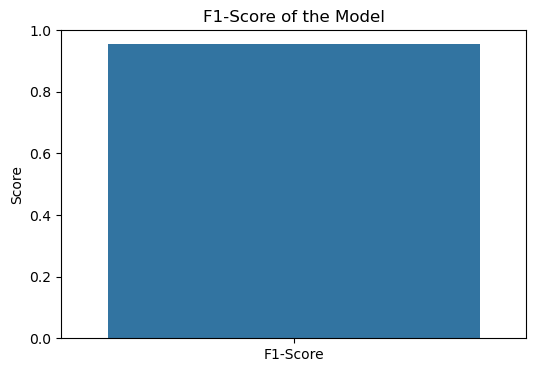

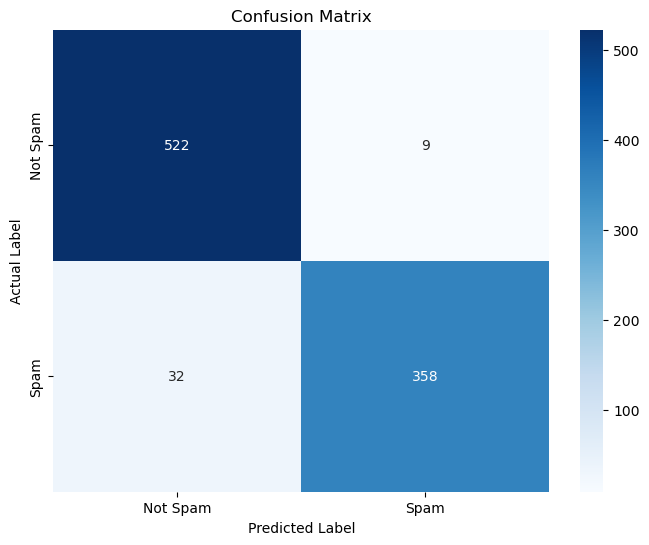

In [17]:
# Calculating F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting F1-score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[f1])
plt.ylim(0, 1)
plt.title('F1-Score of the Model')
plt.ylabel('Score')
plt.show()

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

The weighted average F1-score is approximately 0.955, which indicates that the model has a good balance between precision and recall for the dataset, taking into account the number of instances for each class.

The confusion matrix provides a breakdown of the true positives, false positives, true negatives, and false negatives:

True Non-Spam Predictions: 522
False Spam Predictions (Type I error): 9
False Non-Spam Predictions (Type II error): 32
True Spam Predictions: 358
The model has a higher number of false negatives (32) compared to false positives (9). This suggests that while the model is quite conservative in predicting spam (preferring to minimize false positives), it might be missing some actual spam emails (as indicated by the false negatives). 
Given the high performance metrics across the board, there doesn't seem to be a strong immediate need to balance the dataset further. Both classes are being predicted with high accuracy, precision, and recall, and the F1-scores are also strong. The slight imbalance in the dataset does not seem to be negatively impacting the model's ability to generalize.

We will try to tune the hyperparameters to check if the models performance can be improved:

In [43]:
param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}

rf=RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)

rand_search.fit(X_train,y_train)

best_rf = rand_search.best_estimator_

print("Best hyperparameters:", best_rf)

Best hyperparameters: RandomForestClassifier(max_depth=11, n_estimators=297, random_state=42)
